Created by Ignacio Oguiza - email: oguiza@gmail.com

20200405. Modified by @pomo (Malcolm McLean) to handle variable length timeseries.
20200504. Adapated to fastai2. Added statistics and experiments. Cleaned up.

In [1]:
# Attempt to diagnose a CUDA error...
# from os import environ
# environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
device = 'cuda'
from ROCKETfuncs.ROCKETSound1 import *
from sklearn.linear_model import RidgeClassifierCV

In [40]:
import torch
print('pytorch:', torch.__version__)
device = 'cuda'
import torch.optim as optim
import torch.nn.functional as F

saveAll = all  #Save the Python built-in because fastai2 clobbers it.
from fastai2.vision.all import *
from fastai2 import __version__ as __fai2version
print('fastai2:',__fai2version)  # This is some seriously messed up versioning

from IPython.display import Audio, clear_output # Audio(wav_files[1])
import matplotlib.pyplot as plt
import pathlib
from os import path
HOME = pathlib.Path(path.expanduser("~"))
DATA = pathlib.Path('data')

pytorch: 1.4.0
fastai2: 0.0.18


In [5]:
#My own utility for staying oriented!
from myUtils.showType import ShowType
t = ShowType().type_str
from IPython.display import display, HTML, clear_output
display(HTML("<style>.container { width:100% !important; }</style>"))

### 1️⃣ Generate features

First you prepare the input data and normalize it per sample. The input to ROCKET Pytorch is a 3d tensor (preferrable on gpu)

In [6]:
#Load Macaque calls and name that were saved in a different notebook...
callArray = np.load(str(HOME/'.fastai/data/macaques_24414Hz/callArray.npy'), allow_pickle=True) #This half-baked interpreter won't use ~ for Home.
nameArray = np.load(str(HOME/'.fastai/data/macaques_24414Hz/nameArray.npy'), allow_pickle=True)
t(callArray),t(nameArray)

('ndarray[7285]<object>', 'ndarray[7285]<<U2>')

In [7]:
#Normalize waveforms to mean 0, std 1
def npM0S1(x):
    return (x-x.mean())/(x.std())  #No /0 danger for these samples: min([c.std() for c in callArray])

for i,x in enumerate(callArray):
    callArray[i] = npM0S1(x)

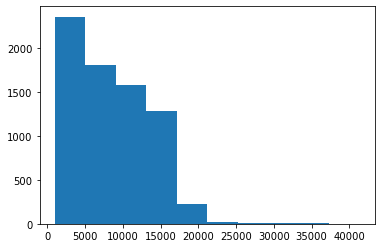

In [8]:
#Take a look at the distribution of sample lengths...
_=plt.hist(([len(x) for x in callArray]))

In [9]:
# Place calls in array, padded with nan on right, sized to the longest sample.
outarr=np.zeros((np.max([len(ps) for ps in callArray]),len(callArray)), dtype=np.float32)*np.nan 
for i,c in enumerate(callArray):  #populate columns
    outarr[:len(c),i]=c

In [10]:
#Format samples for nn.conv1d...
tcalls = torch.tensor(outarr).transpose(0,1).unsqueeze(1)
t(tcalls)

'Tensor(cpu)[7285, 1, 41307]<float32>'

In [ ]:
# #Uncomment this cell to cut down to a small number of samples for testing.

# ncut = 500  #Use this many samples.

# ndx = torch.randperm(len(tcalls)).tolist()
# tcalls = tcalls[ndx]
# tcalls = tcalls[:ncut]

# nameArray = nameArray[ndx]
# nameArray = nameArray[:ncut]
# t(tcalls),t(nameArray)

In [11]:
#Randomize, split into training and validation sets, load audio samples to device.
trainFrac = .8
nt = int(trainFrac*len(tcalls))

indices = torch.randperm(len(tcalls)).tolist()
X_train = tcalls[indices][:nt,:,:].to(device)
X_valid = tcalls[indices][nt:,:,:].to(device)

y_train = nameArray[indices][:nt]
y_valid = nameArray[indices][nt:]

t(X_train),t(X_valid),t(y_train),t(y_valid)

('Tensor(cuda:0)[5828, 1, 41307]<float32>',
 'Tensor(cuda:0)[1457, 1, 41307]<float32>',
 'ndarray[5828]<<U2>',
 'ndarray[1457]<<U2>')

In [12]:
#Sort input and target ascending by length of audio. 
#This greatly speeds up the generation of ROCKET features (see below).
def sortSet(inp,target):
    lengths = torch.isfinite(inp).sum(dim=-1).squeeze() #Number of non-nans is the sample length
    sortIndex = lengths.argsort()   
    return inp[sortIndex],target[sortIndex.cpu()]

X_train,y_train = sortSet(X_train,y_train)
X_valid,y_valid = sortSet(X_valid,y_valid)

In [13]:
#Save in case we want to reproduce this train/val split
DATA.mkdir(exist_ok=True)
torch.save(X_train,DATA/'X_train')
torch.save(y_train,DATA/'y_train')
torch.save(X_valid,DATA/'X_valid')
torch.save(y_valid,DATA/'y_valid')

In [14]:
n_kernels=1000    #10000 is typical. 1000 performs a bit worse but is 10x faster to calculate.
kss=[7, 9, 11]
nfeatures = X_train.shape[1]

In [15]:
#There's a choice here. 
# 1) Tell ROCKET that the sequence length is as long as the longest call. 
# Then it generates conv1d's with large dilations that will be truncated or empty for shorter samples.
# I think this means that ROCKET will not see low-frequency patterns.

# 2) Tell ROCKET the sequence length is as long as the shortest sample. In this case, dilations are smaller, and low frequencies may be invisible.
# But the features calculate much faster, and nn.conv1d stops throwing exception that have to be caught.
# In actual testing, #2 does just as well or better.

# seq_len = X_train.shape[2]  # 1)
seq_len = min(torch.isfinite(X_train).sum(dim=-1).squeeze().min(),torch.isfinite(X_valid).sum(dim=-1).squeeze().min()).item()  #2)

#N.B. When #1 is chosen, default values must be used when the sample is too short for a conv1d to return any values.
#The particular choice of these defaults seems to affect accuracy.
#When #2 is chosen, the conv1d's can handle all samples. The default values do not matter.

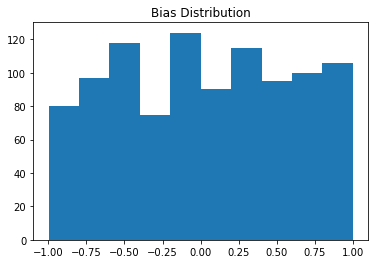

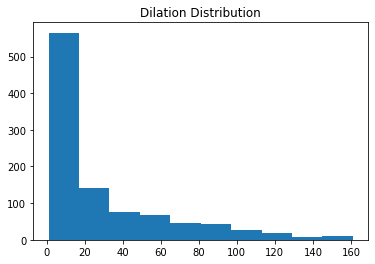

In [16]:
model = ROCKET(nfeatures, seq_len, n_kernels=n_kernels, kss=kss).to(device)  #Generate conv1d's

#Let's plot bias and dilation distributions...
dilations = [c.dilation[0] for c in model.convs]
biases = [c.bias.data.item() for c in model.convs]
plt.hist(biases)
plt.title('Bias Distribution')
plt.show()
plt.hist(dilations)
_ = plt.title('Dilation Distribution')

In [17]:
#Generate ROCKET features from the samples.
#Use smaller batches to prevent CUDA out of memory.

bs = 500

def makeTfm(da,bs):
#We assume that da is sorted by sample length ascending!

    nBatches = (len(da)//bs)+1
    for bi in range(nBatches):
        end = min(bi*bs+bs,len(da))
        batch = da[bi*bs:end] 
        if len(batch)==0:
            break;

        maxlength = torch.isfinite(batch[-1,0,:]).sum()  #Max length of the samples in this batch is length of the last sample
        
        bp = batch[:,:,:maxlength]                       #Process the shortest possible batch length to save time
        print(bi+1,'/',nBatches,'  batch =',t(bp))
        btfm = model(bp)           
        if (bi==0):
            tfm = btfm
        else:
            tfm = torch.cat((tfm,btfm), 0) 
    return tfm

In [18]:
X_train_tfm = makeTfm(X_train,bs)
t(X_train_tfm)

1 / 12   batch = Tensor(cuda:0)[500, 1, 2740]<float32>
2 / 12   batch = Tensor(cuda:0)[500, 1, 3500]<float32>
3 / 12   batch = Tensor(cuda:0)[500, 1, 4240]<float32>
4 / 12   batch = Tensor(cuda:0)[500, 1, 5306]<float32>
5 / 12   batch = Tensor(cuda:0)[500, 1, 6730]<float32>
6 / 12   batch = Tensor(cuda:0)[500, 1, 8093]<float32>
7 / 12   batch = Tensor(cuda:0)[500, 1, 9549]<float32>
8 / 12   batch = Tensor(cuda:0)[500, 1, 11156]<float32>
9 / 12   batch = Tensor(cuda:0)[500, 1, 12772]<float32>
10 / 12   batch = Tensor(cuda:0)[500, 1, 14444]<float32>
11 / 12   batch = Tensor(cuda:0)[500, 1, 16470]<float32>
12 / 12   batch = Tensor(cuda:0)[328, 1, 34823]<float32>


'Tensor(cuda:0)[5828, 2000]<float32>'

In [19]:
X_valid_tfm = makeTfm(X_valid,bs)
t(X_valid_tfm)

1 / 3   batch = Tensor(cuda:0)[500, 1, 5374]<float32>
2 / 3   batch = Tensor(cuda:0)[500, 1, 11258]<float32>
3 / 3   batch = Tensor(cuda:0)[457, 1, 41307]<float32>


'Tensor(cuda:0)[1457, 2000]<float32>'

In [20]:
# #Any nans or infs among the features? Success if none!
# (~torch.isfinite(X_train_tfm)).sum().item(),(~torch.isfinite(X_valid_tfm)).sum().item()

In [21]:
#Save these expensive features.
torch.save(X_train_tfm,DATA/'X_train_tfm')
torch.save(X_valid_tfm,DATA/'X_valid_tfm')

In [22]:
# #Reload features later without recalculating.
# X_valid_tfm = torch.load(DATA/'X_valid_tfm').to(device)
# X_train_tfm = torch.load(DATA/'X_train_tfm').to(device)
# X_train = torch.load(DATA/'X_train')
# y_train = torch.load(DATA/'y_train')
# X_valid = torch.load(DATA/'X_valid')
# y_valid = torch.load(DATA/'y_valid')

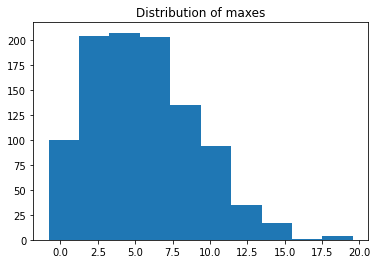

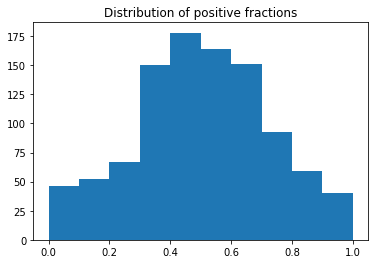

In [23]:
callN = 12  #Visualize the ROCKET features of this one sound sample.
plt.hist(X_train_tfm.cpu()[callN,0::2])
plt.title('Distribution of maxes')
plt.show()

plt.hist(X_train_tfm.cpu()[callN,1::2])
plt.title('Distribution of positive fractions')
plt.show()

In [24]:
# # Appending the call length as an extra feature does NOT help accuracy.
# L_train = np.array([torch.isfinite(c).sum().item() for c in X_train])
# L_valid = np.array([torch.isfinite(c).sum().item() for c in X_valid])
# L_train = npM0S1(L_train)
# L_valid = npM0S1(L_valid)
# X_train_tfm = torch.cat((X_train_tfm,torch.cuda.FloatTensor(L_train).unsqueeze(1)), dim=1)
# X_valid_tfm = torch.cat((X_valid_tfm,torch.cuda.FloatTensor(L_valid).unsqueeze(1)), dim=1)
# t(X_train_tfm)

### 2️⃣ Apply a classifier

#### RidgeClassifierCV

And now you apply a classifier of your choice. 
With RidgeClassifierCV in particular, there's no need to normalize the calculated features before passing them to the classifier, as it does it internally (if normalize is set to True as recommended by the authors).

In [25]:
ridge = RidgeClassifierCV(alphas=np.logspace(-8, 8, 17), normalize=True, fit_intercept=True)
ridge.fit(X_train_tfm.cpu(), y_train)

print('alpha: {:.2E}  train: {:.5f}  valid: {:.5f}'.format(ridge.alpha_, 
                                                           ridge.score(X_train_tfm.cpu(), y_train[:len(X_train_tfm)]), 
                                                           ridge.score(X_valid_tfm.cpu(), y_valid[:len(X_valid_tfm)])))

alpha: 1.00E-02  train: 0.97941  valid: 0.96706


In [26]:
#Convert the two letter labels into integers that PyTorch can use. Place on device.
unames,y_trainN = np.unique(y_train, return_inverse=True)
unames,y_validN = np.unique(y_valid, return_inverse=True)

ttargets = torch.cuda.LongTensor(y_trainN).to(device)
vtargets = torch.cuda.LongTensor(y_validN).to(device)

In [27]:
# Normalize inputs per feature.
# I don't think it's understood why this helps, but it does empirically.
# In this particular example, it adds about 1% to the accuracy.
f_mean = X_train_tfm.mean(dim=0, keepdims=True)
f_std = X_train_tfm.std(dim=0, keepdims=True) +1e-6

X_train_tfm = (X_train_tfm - f_mean) / f_std
X_valid_tfm = (X_valid_tfm - f_mean) / f_std

In [28]:
#The model is simply one Linear layer with weights and biases.
trainModel = nn.Sequential(nn.Linear(X_train_tfm.shape[-1],len(unames))).cuda()

import torch.optim as optim 

# optimizer = optim.Adam(trainModel.parameters(), lr=.005, weight_decay=0)?
optimizer = optim.SGD(trainModel.parameters(), lr=0.001, momentum=0.9)
loss_fn = nn.CrossEntropyLoss()

In [29]:
# PyTorch training loop.

print('epoch   training loss   train accuracy  validation loss    valid accuracy')
for epoch in range(10001):  # loop over the dataset multiple times
    optimizer.zero_grad()

    # forward + backward + step
    tpreds = trainModel(X_train_tfm)
    tloss = loss_fn(tpreds, ttargets)
    with torch.no_grad():
        vpreds = trainModel(X_valid_tfm)
        vloss = loss_fn(vpreds, vtargets)
    if epoch%500 == 0:
        print(epoch,tloss.item(),accuracyCopy(tpreds,ttargets).item(),vloss.item(), accuracyCopy(vpreds,vtargets).item())
    tloss.backward()
    optimizer.step()

epoch   training loss   train accuracy  validation loss    valid accuracy
0 2.499185562133789 0.018188057467341423 2.4920952320098877 0.020590253174304962
500 0.20409467816352844 0.9377144575119019 0.21648404002189636 0.9299930930137634
1000 0.16223110258579254 0.9521276354789734 0.17887701094150543 0.9485243558883667
1500 0.1403024047613144 0.9589910507202148 0.15992844104766846 0.9540150761604309
2000 0.12577202916145325 0.964481770992279 0.14790332317352295 0.9601921439170837
2500 0.11502870917320251 0.9689429998397827 0.13935738801956177 0.9629375338554382
3000 0.10656319558620453 0.9711736440658569 0.13286685943603516 0.965682864189148
3500 0.09961453825235367 0.9725462794303894 0.1277279257774353 0.9663692116737366
4000 0.09375007450580597 0.9746053218841553 0.12354404479265213 0.9670555591583252
4500 0.0887022316455841 0.9768359661102295 0.12006903439760208 0.9691146016120911
5000 0.08429374545812607 0.978208601474762 0.11713965237140656 0.9691146016120911
5500 0.080399274826049

In [30]:
w = trainModel[0].weight.data
# w = torch.tensor(ridge.coef_)  #Alternatively, use the weights that the RidgeClassifier found.

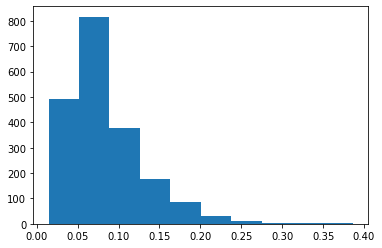

In [31]:
#This plot suggests that many of the ROCKET features are not used for classification.
#What if the unused features were removed, or replaced by other random conv1d's?
_ = plt.hist(w.norm(dim=0).cpu())

In [32]:
from torch.utils.data import Dataset, TensorDataset
all = saveAll  #restore Python built-in function

In [33]:
from torch.utils.data import Dataset,TensorDataset

trainDS = TensorDataset(X_train_tfm,ttargets)  #PyTorch utility for handling this exact situation - sample data is already in Tensors.
validDS = TensorDataset(X_valid_tfm,vtargets)

# Learner.summary(), three levels down, barfs because the original Datasets do not contain n_inp.
# Here I simply set it directly, guessing from the name and from undocumented fastai2 source code what it probably means.
# Forum search fails to search for such a short string.
trainDS.n_inp = 1
validDS.n_inp = 1

In [42]:
batch_size = sys.maxsize  # My GPU can handle the whole epoch at once, thus the full batch size.
# This must be the fastai2 DataLoader, not the PyTorch DataLoader with exactly the same name.
trainDL = DataLoader(trainDS, batch_size=batch_size, drop_last=False, shuffle=False)   #No need to shuffle when batch size == epoch size
validDL = DataLoader(validDS, batch_size=batch_size, drop_last=False, shuffle=False)
dls = DataLoaders(trainDL, validDL).to(device)

In [43]:
# Works?
testBatch = first(dls.train)
print(t(testBatch))

tuple[2]<Tensor(cuda:0)[5828, 2000]<float32>, Tensor(cuda:0)[5828]<int64>>


In [44]:
#The model is simply one Linear layer with weights and biases.
trainModel = nn.Sequential(nn.Linear(X_train_tfm.shape[-1],len(unames))).cuda()

learn = Learner(dls, trainModel, loss_func=F.cross_entropy, metrics=accuracy, opt_func=Adam, cbs=[])
learn.summary()

Sequential (Input shape: ['5828 x 2000'])
Layer (type)         Output Shape         Param #    Trainable 
Linear               5828 x 8             16,008     True      
________________________________________________________________

Total params: 16,008
Total trainable params: 16,008
Total non-trainable params: 0

Optimizer used: <function Adam at 0x7f003478b7a0>
Loss function: <function cross_entropy at 0x7f004118ecb0>

Callbacks:
  - TrainEvalCallback
  - Recorder
  - ProgressCallback

SuggestedLRs(lr_min=0.017378008365631102, lr_steep=0.0006918309954926372)

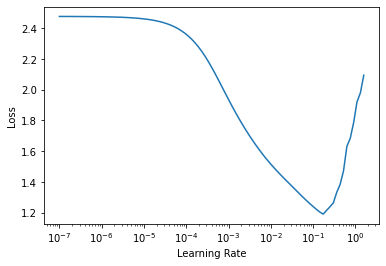

In [45]:
learn.lr_find()

In [46]:
    for i in range(130):
        clear_output(wait=True)
        learn.fit_one_cycle(5, max_lr=3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.042978,0.098865,0.971174,00:00
1,0.042966,0.097699,0.972546,00:00
2,0.042757,0.097277,0.973919,00:00
3,0.042674,0.097178,0.973233,00:00
4,0.042625,0.097140,0.973233,00:00


In [47]:
#97.3% accuracy for this run.

In [48]:
#Let's look at the correlations between bias & dilation of conv1d's vs weights found in training.

# First, get all the conv1d parameters into a numpy array. Inefficient but easy to work with.
# The parameters are in columns, [kernel_size, dilation, bias]. rows correspond to each conv1d.
# (BTW, it took me 5 minutes of experimentation to write this one line.)
kdb = np.array([[c.kernel_size[0],c.dilation[0],c.bias.item()] for c in model.convs])
t(kdb)

'ndarray[1000, 3]<float64>'

In [49]:
dilations = kdb[:,1]   
biases = kdb[:,2]       
klengths = kdb[:,0]   

In [50]:
# Next, get the weight norms over all categories, separated into max and ppv, that were found for each conv1d.
w = trainModel[0].weight.data
wn2col = w.norm(dim=0).view(-1,2).cpu() #Norm of weights on max is column 0. Norm of weights on ppv is column 2.
print(t(wn2col))

Tensor(cpu)[1000, 2]<float32>


In [51]:
# Here's an alternative way to look at the most significant weights,
# by the largest magnitude weight, across all categories, given to each conv1d.
# wn2col = w.abs().max(dim=0)[0].view(-1,2).cpu()

Text(0.5, 1.0, 'Dilation vs. Weight norm (ppv,max)')

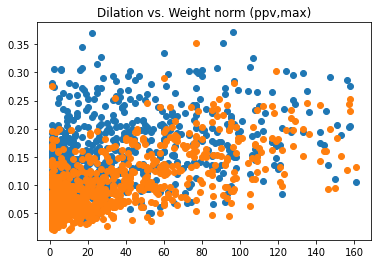

In [52]:
plt.scatter(dilations, wn2col[:,1])
plt.scatter(dilations, wn2col[:,0])
plt.title('Dilation vs. Weight norm (ppv,max)')
# Smaller dilations seem more important, with a peak at 20-40.

Text(0.5, 1.0, 'Bias vs. Weight norm (ppv,max)')

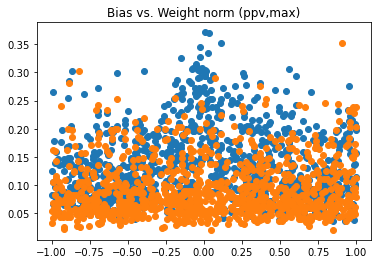

In [54]:
plt.scatter(biases, wn2col[:,1])
plt.scatter(biases, wn2col[:,0])
plt.title('Bias vs. Weight norm (ppv,max)')
# We see that important dilations are centered around zero.

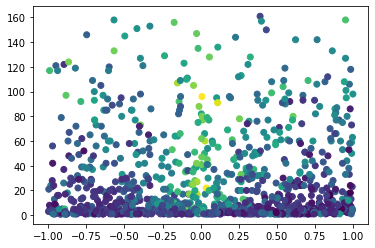

In [55]:
# Bias vs. Dilation vs. ppv as color.
plt.scatter(biases, dilations, c=wn2col[:,1])

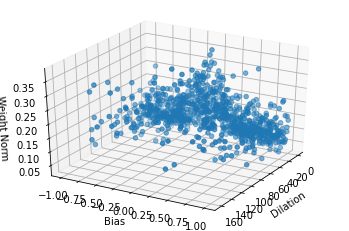

In [56]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(dilations, biases, wn2col[:,1], marker='o')

ax.set_xlabel('Dilation')
ax.set_ylabel('Bias')
ax.set_zlabel('Weight Norm')

ax.view_init(30, 30)